In [114]:
from pathlib import Path
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from branca.element import Template, MacroElement
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


In [3]:
# Image output folder
map_folder = Path(r"C:\Users\clemettn\Documents\phd\data\WP01"
                    r"\site_selection")
map_folder.mkdir(parents=True, exist_ok=True)

# Hazard map file path
hazard_maps_folder = Path(r"C:\Users\clemettn\Documents\phd\data" \
                          r"\eshm20_hazard_maps")

mafe_sd = "0pt21"            # mafe for determing seismicity category
mafe_sel = "0pt04"            # mafe for record selection

# EU Coutnries shapefile path
eu_countries_fp = Path(r"C:\Users\clemettn\Documents\phd\data\eu_shapefile"
                       r"\Europe_merged.shp")

# ESHM20 attenuation zones
atten_zones_fp = Path(r"C:\Users\clemettn\Documents\phd\data"
                      r"\eshm20_attenutation_regions")

# ESHM20 site model
site_model_fp = Path(r"C:\Users\clemettn\Documents\phd\data"
                      r"\eshm20_oq_models\eshm20_site_model_v06d.csv")

# selected sites
selected_sites_fp = Path(r"C:\Users\clemettn\Documents\phd\data\WP01\sites.csv")

In [4]:
# helper for fomatting pt strings to float
def pt_to_float(s):
    parts = s.split("pt")
    return float(parts[0] + "." + parts[1])

In [122]:
# colour_map attenuation regions:
colour_map = {0: "firebrick",
             1: "lime", 
             2: "deeppink", 
             3: "aqua", 
             4: "gold", 
             5: "royalblue"}

# label_map attenuation_regions
atten_label_map = {0: "Default",
             1: "Slow", 
             2: "Fast", 
             3: "v. Fast", 
             4: "Central", 
             5: "v. Slow"}

# another colour map
okabe_ito_6 = [
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#009E73",  # bluish green
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#CC79A7",  # reddish purple
]

seismicity_symbols = {"lowmod": "o",
                      "high": "s"}


def add_folium_legend(m, labels, colours, title="Deviation bins"):
    html = (
        "<div id='maplegend' style=\"position:fixed; "
        "bottom:30px; left:30px; width:220px; z-index:9999; "
        "font-size:14px; background-color: rgba(255,255,255,0.9); "
        "padding:10px; border-radius:8px; border:1px solid #ccc;\">"
        f"<b>{title}</b><br>"
    )

    for label, col in zip(labels, colours):
        html += (
            "<div style=\"display:flex; align-items:center; "
            "margin-bottom:4px;\">"
            f"<div style=\"background:{col}; width:18px; height:18px; "
            "border:1px solid #555; margin-right:8px;\"></div>"
            f"{label}</div>"
        )

    html += "</div>"

    # build the jinja wrapper WITHOUT an f-string
    tpl = "{% macro html(this, kwargs) %}" + html + "{% endmacro %}"

    legend = MacroElement()
    legend._template = Template(tpl)
    m.get_root().add_child(legend)


# Load Data

In [6]:
# Load a shapefiles into GeoDataFrames
# Hazard Maps
hazard_map_files = list(hazard_maps_folder.glob("*.shp"))
hazard_maps = {}

for fp in hazard_map_files:
    
    split_name = fp.stem.split("_")
    mafe = split_name[1][:-6]
    period = pt_to_float(split_name[2][:-1])
    gdf = gpd.read_file(fp)
    gdf.rename(columns={"HPVALUE": f"{period}"}, inplace=True)
    gdf.columns = pd.MultiIndex.from_product([[f"{mafe}pc_mafe"], gdf.columns])
    gdf.set_geometry((f"{mafe}pc_mafe", "geometry"), inplace=True) 
    hazard_maps[(mafe, period)] = gdf

# EU Countries
gdf_eu = gpd.read_file(eu_countries_fp)
print("EU Countries\n", gdf_eu.head(), "\n")

# ESHM20 Attenuation Zones
atten_zones = gpd.read_file(atten_zones_fp)
atten_zones.set_crs(epsg=4326, inplace=True)
print("Attenuation Zones\n", atten_zones.head(), "\n")
regions = {i : atten_zones[atten_zones['REGION'] == i] 
           for i in atten_zones['REGION'].unique()}

# ESHM020 Site Model
site_model = pd.read_csv(site_model_fp)
gdf_sites = gpd.GeoDataFrame(site_model,
                             geometry=gpd.points_from_xy(site_model.lon,
                                                         site_model.lat),
                             crs="EPSG:4326")
gdf_sites.head()
print("Site Model\n", gdf_sites.head(), "\n")

EU Countries
   GID_0   COUNTRY                                           geometry
0   ALB   Albania  MULTIPOLYGON (((20.05408 39.69171, 20.03888 39...
1   BEL   Belgium  MULTIPOLYGON (((5.46629 49.49893, 5.4645 49.50...
2   BGR  Bulgaria  MULTIPOLYGON (((25.12868 41.32243, 25.12824 41...
3   HRV   Croatia  MULTIPOLYGON (((16.80109 42.74768, 16.80125 42...
4   CYP    Cyprus  MULTIPOLYGON (((33.67944 35.0339, 33.685 35.02... 

Attenuation Zones
                   NAME  REGION  \
0       Adriatic North       1   
1       Adriatic South       2   
2         Aegean North       2   
3         Aegean South       3   
4  Aegean Volcanic Arc       3   

                                            geometry  
0  POLYGON ((13.78488 43.91177, 13.49697 43.96495...  
1  POLYGON ((14.52178 42.21122, 14.55307 42.30117...  
2  POLYGON ((26.95757 39.13752, 26.96797 38.80451...  
3  POLYGON ((21.83669 38.23371, 21.96789 38.14107...  
4  POLYGON ((22.64549 37.96761, 22.91324 37.92073...   

Site Model
   

In [7]:
# Get the hazard values for all of the sites
site_hazard_gdfs = [gpd.sjoin(gdf_sites, h, how="left", predicate='within') for h in hazard_maps.values()]

# there are some instances where the polygons overlap, leading to duplicate indices
# the first occurence of each index is kept, the other duplicates are dropped
site_hazard_gdfs = [sh.loc[~sh.index.duplicated(keep="first")] 
                    for sh in site_hazard_gdfs]
site_hazard_gdfs = [sh.drop(columns=["index_right"]) for sh in site_hazard_gdfs]
site_hazard = pd.concat([site_hazard_gdfs[0], *[s.drop(columns=["geometry"]) 
                                           for s in site_hazard_gdfs]], axis=1)
# Remove duplicate columns (keeping the first occurrence)
site_hazard = site_hazard.loc[:, ~site_hazard.columns.duplicated()]

metadata_columns = [c for c in site_hazard.columns if not isinstance(c, tuple)]
new_metadata_columns = pd.Index([("metadata", c) for c in metadata_columns])
site_hazard.rename(columns=dict(zip(metadata_columns, new_metadata_columns)), 
                   inplace=True)
new_columns = pd.MultiIndex.from_tuples(site_hazard.columns)
site_hazard.columns = new_columns
site_hazard.set_geometry(("metadata", "geometry"), inplace=True)

# remove rows with missing hazard values
site_hazard.dropna(inplace=True)
site_hazard.head()

metadata                                                         \
       lat       lon region vs30 vs30measured    xvf  z1pt0 z2pt5   
2     34.5  32.48213      2  800         True  150.0  31.07  0.57   
3     34.5  32.58213      2  800         True  150.0  31.07  0.57   
4     34.5  32.68213      2  800         True  150.0  31.07  0.57   
5     34.5  32.78213      2  800         True  150.0  31.07  0.57   
6     34.5  32.88213      2  800         True  150.0  31.07  0.57   

                         0pt04pc_mafe  ...                                \
                geometry          0.0  ...       0.6      0.75       1.0   
2  POINT (32.48213 34.5)     0.934705  ...  0.937454  0.753607  0.565350   
3  POINT (32.58213 34.5)     0.854351  ...  0.877165  0.707351  0.533329   
4  POINT (32.68213 34.5)     0.711445  ...  0.752583  0.619573  0.469568   
5  POINT (32.78213 34.5)     0.637850  ...  0.701273  0.577693  0.439133   
6  POINT (32.88213 34.5)     0.740051  ...  0.828295  0.675681  0.511990   

                                          0pt21pc_mafe                      
        2.0       3.0       4.0       5.0          0.1      0.15       0.2  
2  0.205468  0.111202  0.073780  0.051014     0.882375  0.975446  0.900323  
3  0.196124  0.106644  0.070948  0.049256     0.832663  0.911635  0.843354  
4  0.178188  0.097481  0.065625  0.046094     0.749992  0.809120  0.753201  
5  0.169997  0.093888  0.063587  0.044981     0.713810  0.767128  0.716321  
6  0.194818  0.107303  0.071914  0.050353     0.783683  0.848367  0.794515  

[5 rows x 29 columns]

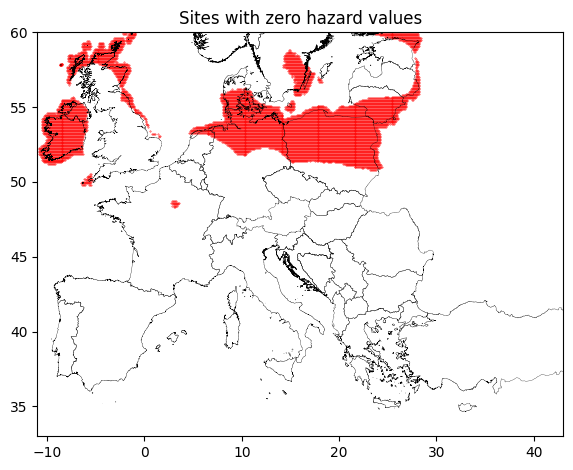

In [8]:
# plot the sites that have a zero value for any of the hazard levels
zero_haz_sites = site_hazard[site_hazard.loc[:, site_hazard.columns.get_level_values(0) != "metadata"]
                             .le(0).any(axis=1)]
fig, ax = plt.subplots()
zero_haz_sites.plot(ax=ax, marker='o', color='red', markersize=0.1)
gdf_eu.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)

ax.set_title("Sites with zero hazard values")
ax.set_xlim(-11, 43)
ax.set_ylim(33, 60)
plt.tight_layout()

In [9]:
# remove sites with zero hazard values --> They will cause problems with log calculations
site_hazard = site_hazard[~site_hazard.index.isin(zero_haz_sites.index)]

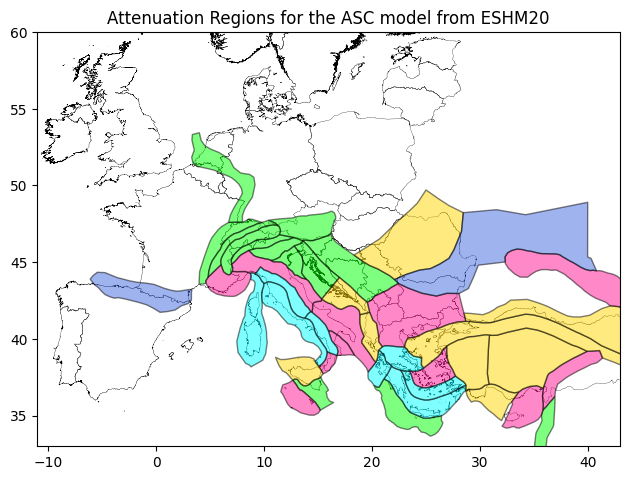

In [10]:
# plot the attenuation regions:
fig, ax = plt.subplots()
gdf_eu.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)
for region, color in colour_map.items():
    if region in regions.keys():
        regions[region].plot(ax=ax, color=color, edgecolor="k", 
                             label=f"Region {region}", alpha=0.5)

ax.set_title("Attenuation Regions for the ASC model from ESHM20")
ax.set_xlim(-11, 43)
ax.set_ylim(33, 60)
plt.tight_layout()


# Add Average SA IMs

## Avg SA for record selection

The site selection is on the basis of the Avg.SA values calculated from the hazard map values for the 0.04% MAFE (2500 RTP).
The IM $SA_{avg}: [0, 0.33, 0.66, 0.99, 1.33, 1.67, 2.00, 2.33, 2.66, 3.00]$ will be used to assess what sites are suitable.

Note that this calculation of AvgSA is an approximation. It has been calculated using Hazard Map values for each SA value which incorporate all the Logic Tree branches. Using the indirect approach the AvgSA should be calculated at the rupture level (i.e. for each rupture context) and then the hazard curves maps are calculated from the results.

In [11]:
# Average SA for record selection - 0.04% MAFE
periods_for_avgSA = [0, 0.33, 0.66, 0.99, 1.33, 1.67, 2.00, 2.33, 2.66, 3.00]
AvgSA_label = "Avg.SA(0->3s)"

# get the hazard_data an interpolate missing periods
haz_data = site_hazard[f"{mafe_sel}pc_mafe"]
haz_data.columns = haz_data.columns.astype(float)
periods_to_interp = [p for p in periods_for_avgSA if not p in haz_data.columns]

log_haz_data = np.log(haz_data)
haz_data = np.exp(log_haz_data.reindex(columns=log_haz_data.columns.union(periods_to_interp)) \
            .sort_index(axis=1) \
            .interpolate(axis=1, method='index'))

# calculate Avg.SA
haz_data[AvgSA_label] = (haz_data[periods_for_avgSA].prod(axis=1)) ** (1/len(periods_for_avgSA))

# # add these back to the site_hazard GeoDataFrame
data_to_add = haz_data[[AvgSA_label]+periods_to_interp]
data_to_add.columns = pd.MultiIndex.from_product([[f"{mafe_sel}pc_mafe"], 
                                                  data_to_add.columns.astype(str)])
site_hazard = pd.concat([site_hazard, data_to_add], axis=1)
site_hazard = site_hazard.reindex(columns=sorted(site_hazard.columns, key=str))

In [12]:
haz_data

,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.33,0.35,0.4,...,1.0,1.33,1.67,2.0,2.33,2.66,3.0,4.0,5.0,Avg.SA(0->3s)
2,0.934705,1.202733,2.021472,2.309848,2.148534,1.889449,1.678284,1.592487,1.537740,1.412642,...,0.565350,0.404816,0.286948,0.205468,0.167786,0.137015,0.111202,0.073780,0.051014,0.367242
3,0.854351,1.134520,1.880233,2.110252,1.964614,1.739303,1.548965,1.463130,1.408565,1.306506,...,0.533329,0.383373,0.272837,0.196124,0.160404,0.131189,0.106644,0.070948,0.049256,0.346548
4,0.711445,0.998509,1.627968,1.764074,1.643567,1.458400,1.291881,1.221382,1.176533,1.084733,...,0.469568,0.341058,0.245329,0.178188,0.146027,0.119670,0.097481,0.065625,0.046094,0.306413
5,0.637850,0.940333,1.510258,1.615724,1.498023,1.335016,1.186648,1.121163,1.079527,0.988986,...,0.439133,0.321059,0.232516,0.169997,0.139752,0.114888,0.093888,0.063587,0.044981,0.288116
6,0.740051,1.059275,1.706701,1.858232,1.743998,1.579233,1.399451,1.321247,1.271554,1.171971,...,0.511990,0.372206,0.267984,0.194818,0.160012,0.131425,0.107303,0.071914,0.050353,0.333357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94488,0.024037,0.033875,0.054504,0.060697,0.057856,0.052782,0.046327,0.042760,0.040536,0.036556,...,0.012796,0.009136,0.006456,0.004609,0.003800,0.003134,0.002569,0.001693,0.001187,0.008653
94489,0.021700,0.030848,0.049457,0.054630,0.051823,0.046995,0.041173,0.038126,0.036220,0.032651,...,0.011224,0.008026,0.005681,0.004062,0.003335,0.002739,0.002236,0.001465,0.001017,0.007635
94490,0.021290,0.030259,0.048459,0.053584,0.050813,0.045996,0.040342,0.037381,0.035529,0.032033,...,0.010989,0.007860,0.005565,0.003980,0.003265,0.002678,0.002183,0.001431,0.000992,0.007476
94491,0.020869,0.029633,0.047433,0.052509,0.049754,0.044991,0.039517,0.036647,0.034850,0.031436,...,0.010782,0.007712,0.005461,0.003906,0.003206,0.002631,0.002146,0.001407,0.000974,0.007336


In [13]:
site_hazard

0pt04pc_mafe                                                    \
               0.0      0.05       0.1      0.15       0.2      0.25   
2         0.934705  1.202733  2.021472  2.309848  2.148534  1.889449   
3         0.854351  1.134520  1.880233  2.110252  1.964614  1.739303   
4         0.711445  0.998509  1.627968  1.764074  1.643567  1.458400   
5         0.637850  0.940333  1.510258  1.615724  1.498023  1.335016   
6         0.740051  1.059275  1.706701  1.858232  1.743998  1.579233   
...            ...       ...       ...       ...       ...       ...   
94488     0.024037  0.033875  0.054504  0.060697  0.057856  0.052782   
94489     0.021700  0.030848  0.049457  0.054630  0.051823  0.046995   
94490     0.021290  0.030259  0.048459  0.053584  0.050813  0.045996   
94491     0.020869  0.029633  0.047433  0.052509  0.049754  0.044991   
94492     0.020421  0.028954  0.046339  0.051368  0.048543  0.043938   

                                               ... 0pt21pc_mafe  \
            0.3      0.33      0.35       0.4  ...          0.2   
2      1.678284  1.592487  1.537740  1.412642  ...     0.900323   
3      1.548965  1.463130  1.408565  1.306506  ...     0.843354   
4      1.291881  1.221382  1.176533  1.084733  ...     0.753201   
5      1.186648  1.121163  1.079527  0.988986  ...     0.716321   
6      1.399451  1.321247  1.271554  1.171971  ...     0.794515   
...         ...       ...       ...       ...  ...          ...   
94488  0.046327  0.042760  0.040536  0.036556  ...     0.011783   
94489  0.041173  0.038126  0.036220  0.032651  ...     0.009717   
94490  0.040342  0.037381  0.035529  0.032033  ...     0.009418   
94491  0.039517  0.036647  0.034850  0.031436  ...     0.009181   
94492  0.038655  0.035880  0.034142  0.030815  ...     0.008953   

                    metadata                                                  \
                    geometry   lat       lon region vs30 vs30measured    xvf   
2      POINT (32.48213 34.5)  34.5  32.48213      2  800         True  150.0   
3      POINT (32.58213 34.5)  34.5  32.58213      2  800         True  150.0   
4      POINT (32.68213 34.5)  34.5  32.68213      2  800         True  150.0   
5      POINT (32.78213 34.5)  34.5  32.78213      2  800         True  150.0   
6      POINT (32.88213 34.5)  34.5  32.88213      2  800         True  150.0   
...                      ...   ...       ...    ...  ...          ...    ...   
94488  POINT (26.38213 71.3)  71.3  26.38213      5  800         True  150.0   
94489  POINT (27.18213 71.3)  71.3  27.18213      5  800         True  150.0   
94490  POINT (27.28213 71.3)  71.3  27.28213      5  800         True  150.0   
94491  POINT (27.38213 71.3)  71.3  27.38213      5  800         True  150.0   
94492  POINT (27.48213 71.3)  71.3  27.48213      5  800         True  150.0   

                    
       z1pt0 z2pt5  
2      31.07  0.57  
3      31.07  0.57  
4      31.07  0.57  
5      31.07  0.57  
6      31.07  0.57  
...      ...   ...  
94488  31.07  0.57  
94489  31.07  0.57  
94490  31.07  0.57  
94491  31.07  0.57  
94492  31.07  0.57  

[76952 rows x 37 columns]

In [14]:
haz_data = site_hazard[f"{mafe_sel}pc_mafe"]
haz_data.drop(columns=[AvgSA_label], inplace=True)
haz_data.columns = haz_data.columns.astype(float)
periods_to_interp = [p for p in periods_for_avgSA if not p in haz_data.columns]
log_haz_data = np.log(haz_data)
log_haz_data

C:\Users\clemettn\AppData\Local\Temp\ipykernel_33036\2981900624.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  haz_data.drop(columns=[AvgSA_label], inplace=True)


,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.33,0.35,0.40,...,0.99,1.00,1.33,1.67,2.00,2.33,2.66,3.00,4.00,5.00
2,-0.067524,0.184597,0.703826,0.837182,0.764786,0.636285,0.517772,0.465297,0.430314,0.345462,...,-0.558813,-0.570310,-0.904322,-1.248455,-1.582467,-1.785067,-1.987667,-2.196406,-2.606670,-2.975650
3,-0.157413,0.126210,0.631396,0.746808,0.675296,0.553484,0.437587,0.380578,0.342572,0.267356,...,-0.617322,-0.628617,-0.958747,-1.298881,-1.629011,-1.830062,-2.031112,-2.238256,-2.645801,-3.010715
4,-0.340457,-0.001492,0.487332,0.567626,0.496869,0.377340,0.256100,0.199983,0.162572,0.081334,...,-0.744854,-0.755943,-1.075704,-1.405155,-1.724916,-1.923967,-2.123018,-2.328100,-2.723799,-3.077081
5,-0.449652,-0.061521,0.412280,0.479783,0.404146,0.288943,0.171133,0.114367,0.076523,-0.011076,...,-0.811982,-0.822952,-1.136130,-1.458798,-1.771976,-1.967888,-2.163800,-2.365648,-2.755345,-3.101510
6,-0.301036,0.057585,0.534562,0.619625,0.556180,0.456939,0.336080,0.278576,0.240240,0.158687,...,-0.658353,-0.669449,-0.988308,-1.316829,-1.635688,-1.832504,-2.029319,-2.232099,-2.632287,-2.988703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94488,-3.728168,-3.385081,-2.909473,-2.801860,-2.849795,-2.941594,-3.072038,-3.152158,-3.205571,-3.308917,...,-4.344991,-4.358598,-4.695562,-5.042738,-5.379702,-5.572625,-5.765547,-5.964316,-6.381060,-6.736119
94489,-3.830426,-3.478683,-3.006654,-2.907172,-2.959919,-3.057719,-3.189966,-3.266869,-3.318137,-3.421880,...,-4.475632,-4.489668,-4.825092,-5.170682,-5.506106,-5.703135,-5.900163,-6.103162,-6.526223,-6.890712
94490,-3.849526,-3.497950,-3.027042,-2.926508,-2.979605,-3.079195,-3.210357,-3.286592,-3.337416,-3.441000,...,-4.496784,-4.510880,-4.846031,-5.191337,-5.526488,-5.724608,-5.922728,-6.126852,-6.549703,-6.915314
94491,-3.869478,-3.518870,-3.048445,-2.946780,-3.000665,-3.101298,-3.231019,-3.306429,-3.356703,-3.459799,...,-4.515800,-4.529922,-4.864963,-5.210157,-5.545198,-5.742884,-5.940570,-6.144246,-6.566012,-6.933608


In [15]:
(haz_data <= 0).any()
type(haz_data[0.0].where(haz_data[0.0] <= 0))

pandas.core.series.Series

In [16]:
# Create a boolean mask where the condition (value <= 0) is True
mask = haz_data <= 0

# Use np.where on the mask to get the (row_indices, col_indices) as a tuple of arrays
row_indices, col_indices = np.where(mask)

# 3. Combine the results into a list of (row_index, column_name) tuples
# We use df.columns[col_indices] to convert the column index numbers to column names

# Create a list of tuples: (row index, column name)
indices = list(zip(haz_data.index[row_indices], haz_data.columns[col_indices]))

# 4. Print the results
print("Indices (row index, column name) of values <= 0:")
print(len(indices))
print(indices)
print(haz_data.columns[np.unique(col_indices)])

Indices (row index, column name) of values <= 0:
0
[]
Index([], dtype='float64')


## Plateau SA

In [17]:
# SA for plateau - 0.21% MAFE. Average of SA(0.1), SA(0.15) and SA(0.2)
SA_label = "SA(plateau)"
periods_for_plateau = [0.1, 0.15, 0.2]
periods_for_plateau = [str(p) for p in periods_for_plateau]

# get the hazard_data an interpolate missing periods
haz_data = site_hazard[f"{mafe_sd}pc_mafe"]

# calculate plateau SA
haz_data.loc[:, SA_label] = (haz_data[periods_for_plateau].sum(axis=1)) / \
                            len(periods_for_plateau)

# add these back to the site_hazard GeoDataFrame
site_hazard.loc[:, ("0pt21pc_mafe", SA_label)] = \
    haz_data[SA_label]
# site_hazard = site_hazard.reindex(columns=sorted(site_hazard.columns, key=str))
site_hazard = site_hazard.sort_index(axis=1, level=[0, 1], ascending=[False, True], 
                                     key=lambda x: x.astype(str))

C:\Users\clemettn\AppData\Local\Temp\ipykernel_33036\3747869676.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  haz_data.loc[:, SA_label] = (haz_data[periods_for_plateau].sum(axis=1)) / \


In [18]:
haz_data["SA(plateau)"].describe()

count    76952.000000
mean         0.208783
std          0.281207
min          0.003642
25%          0.023037
50%          0.067535
75%          0.302837
max          2.142668
Name: SA(plateau), dtype: float64

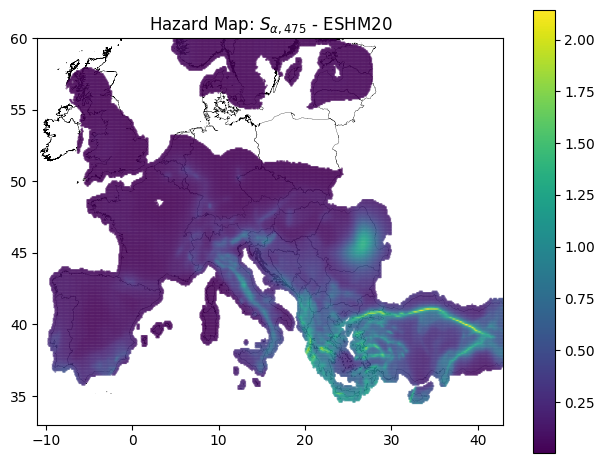

In [19]:
# SA(plateau) [g] for 0.21% MAFE
fig, ax = plt.subplots()
gdf_eu.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)
site_hazard.plot(ax=ax, column=("0pt21pc_mafe", "SA(plateau)"), cmap='viridis', 
                 legend=True, alpha=0.8, marker='o', markersize=0.15)
ax.set_title(r"Hazard Map: $S_{\alpha,475}$ - ESHM20")
ax.set_xlim(-11, 43)
ax.set_ylim(33, 60)
plt.tight_layout()

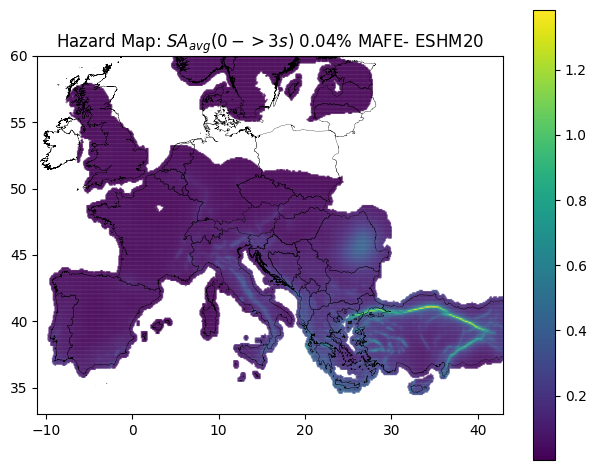

In [20]:
# Avg.SA(0->3s) [g] for 0.04% MAFE
fig, ax = plt.subplots()
site_hazard.plot(ax=ax, column=("0pt04pc_mafe", "Avg.SA(0->3s)"), cmap='viridis', 
                 legend=True, alpha=1, marker='o', markersize=0.1)
gdf_eu.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)
ax.set_title(r"Hazard Map: $SA_{avg}(0->3s)$ 0.04% MAFE- ESHM20")
ax.set_xlim(-11, 43)
ax.set_ylim(33, 60)
plt.tight_layout()

In [21]:
site_hazard[("0pt04pc_mafe", "Avg.SA(0->3s)")].describe()

count    76952.000000
mean         0.082179
std          0.117478
min          0.002996
25%          0.008251
50%          0.026601
75%          0.119177
max          1.382496
Name: (0pt04pc_mafe, Avg.SA(0->3s)), dtype: float64

# Selecting Sites

## Seismicity Categories

In [22]:
# Seismicity categories based on EC8 draft §5.2.1 Table 5.2
# 475 yr return period, mean(SA(0.1s), SA(0.15s), SA(0.2s)) in g
g = 9.81  # m/s²

site_hazard_vlow = site_hazard[
    site_hazard[('0pt21pc_mafe', 'SA(plateau)')] * g <= 1.0]

site_hazard_low = site_hazard[(
    1.0 <= site_hazard[('0pt21pc_mafe', 'SA(plateau)')] * g) 
    & (site_hazard[('0pt21pc_mafe', 'SA(plateau)')] * g <= 2.5)]

site_hazard_mod = site_hazard[
    (2.5 <= site_hazard[('0pt21pc_mafe', 'SA(plateau)')] * g) 
    & (site_hazard[('0pt21pc_mafe', 'SA(plateau)')] * g <= 5.0)]

site_hazard_high = site_hazard[
    5.0 <= site_hazard[('0pt21pc_mafe', 'SA(plateau)')] * g]

site_hazard_lowmod = site_hazard[
    (1.0 <= site_hazard[('0pt21pc_mafe', 'SA(plateau)')] * g) 
    & (site_hazard[('0pt21pc_mafe', 'SA(plateau)')] * g <= 5.0)]

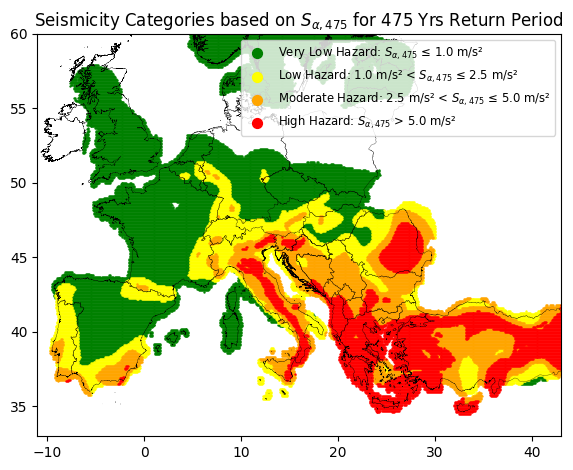

In [23]:
fig, ax = plt.subplots()
alpha = 1
markersize = 0.5
marker = "o"

site_hazard_vlow.plot(ax=ax, color = "green", marker=marker, 
                      markersize=markersize, alpha=alpha, 
                      label=r"Very Low Hazard: $S_{\alpha,475}$ ≤ 1.0 m/s²")
site_hazard_low.plot(ax=ax, color="yellow", marker=marker, 
                     markersize=markersize, alpha=alpha, 
                     label=r"Low Hazard: 1.0 m/s² < $S_{\alpha,475}$ ≤ 2.5 m/s²")
site_hazard_mod.plot(ax=ax, color="orange", marker=marker, 
                     markersize=markersize,  alpha=alpha, 
                     label=r"Moderate Hazard: 2.5 m/s² < $S_{\alpha,475}$ ≤ 5.0 m/s²")
site_hazard_high.plot(ax=ax, color="red", marker=marker, 
                      markersize=markersize, alpha=alpha, 
                      label=r"High Hazard: $S_{\alpha,475}$ > 5.0 m/s²")
gdf_eu.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)

ax.set_title(r"Seismicity Categories based on $S_{\alpha,475}$ for 475 Yrs Return Period")
ax.set_xlim(-11, 43)
ax.set_ylim(33, 60)
ax.legend(markerscale=10, fontsize='small', loc='upper right')
plt.tight_layout()

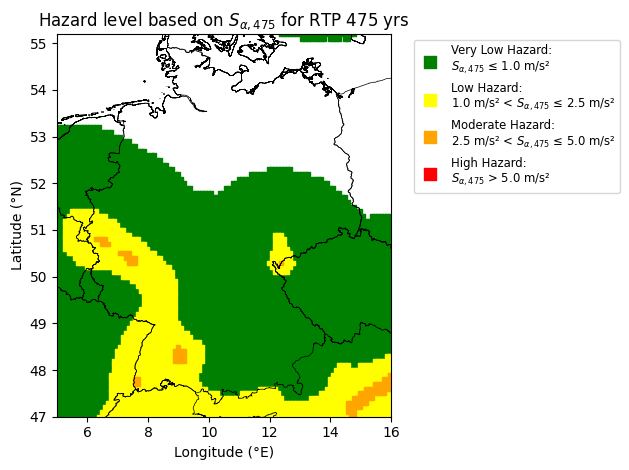

In [89]:
fig, ax = plt.subplots()
alpha = 1
markersize = 5.0
marker = "s"

site_hazard_vlow.plot(ax=ax, color = "green", marker=marker, 
                      markersize=markersize, alpha=alpha, 
                      label=("Very Low Hazard: \n" + 
                             r"$S_{\alpha,475}$ ≤ 1.0 m/s²"))
site_hazard_low.plot(ax=ax, color="yellow", marker=marker, 
                     markersize=markersize, alpha=alpha, 
                     label=("Low Hazard: \n" + 
                            r"1.0 m/s² < $S_{\alpha,475}$ ≤ 2.5 m/s²"))
site_hazard_mod.plot(ax=ax, color="orange", marker=marker, 
                     markersize=markersize,  alpha=alpha, 
                     label=("Moderate Hazard: \n" + 
                            r"2.5 m/s² < $S_{\alpha,475}$ ≤ 5.0 m/s²"))
site_hazard_high.plot(ax=ax, color="red", marker=marker, 
                      markersize=markersize, alpha=alpha, 
                      label=("High Hazard: \n" + 
                             r"$S_{\alpha,475}$ > 5.0 m/s²"))
gdf_eu.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)

ax.set_title(r"Hazard level based on $S_{\alpha,475}$ for RTP 475 yrs")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_xlim(5, 16)
ax.set_ylim(47, 55.2)
plt.legend(markerscale=4, fontsize='small', bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

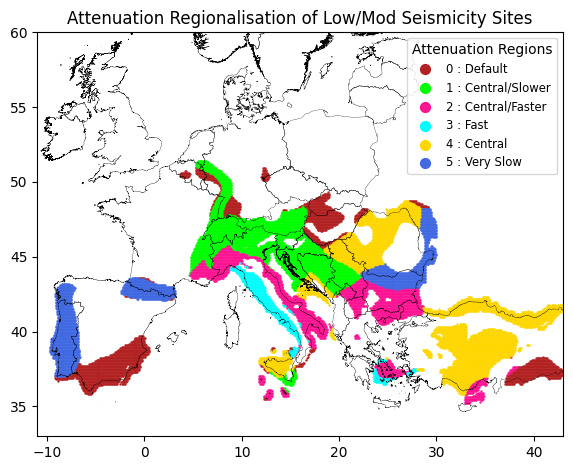

In [24]:
# Low/Mod seismicity sites by attenuation region
fig, ax = plt.subplots()
alpha = 1
markersize = 0.5
marker = "o"

for region, colour in colour_map.items():
    data_to_plot = site_hazard_lowmod[
        site_hazard_lowmod[("metadata", "region")] == region]
    data_to_plot.plot(ax=ax, color=colour, marker=marker, 
                      markersize=markersize, alpha=alpha, 
                      label=f"{region} : {atten_label_map[region]}")
gdf_eu.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)

ax.set_title(r"Attenuation Regionalisation of Low/Mod Seismicity Sites")
ax.set_xlim(-11, 43)
ax.set_ylim(33, 60)
ax.legend(title="Attenuation Regions", markerscale=10, fontsize='small', 
          loc='upper right')
plt.tight_layout()

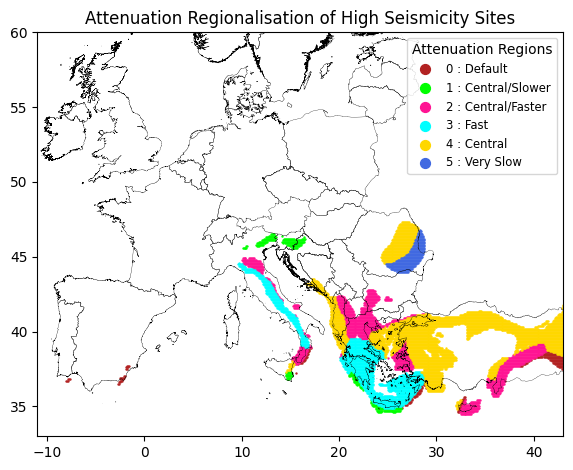

In [25]:
# High seismicity sites by attenuation region
fig, ax = plt.subplots()
alpha = 1
markersize = 0.5
marker = "o"

for region, colour in colour_map.items():
    data_to_plot = site_hazard_high[
        site_hazard_high[("metadata", "region")] == region]
    data_to_plot.plot(ax=ax, color=colour, marker=marker, 
                      markersize=markersize, alpha=alpha, 
                      label=f"{region} : {atten_label_map[region]}")
gdf_eu.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)

ax.set_title(r"Attenuation Regionalisation of High Seismicity Sites")
ax.set_xlim(-11, 43)
ax.set_ylim(33, 60)
ax.legend(title="Attenuation Regions", markerscale=10, fontsize='small', 
          loc='upper right')
plt.tight_layout()

In [26]:
# get a statistical description of AvgSA for each level of seismicity and region
stats = []
for data, label in zip([site_hazard_lowmod, site_hazard_high], 
                        ["lowmod", "high"]):
    for region in atten_label_map.keys():
        region_data = data[data[("metadata", "region")] == region]
        region_stats = region_data[("0pt04pc_mafe", AvgSA_label)].describe()
        region_stats = region_stats.rename((label, region)) 
        stats.append(region_stats)  

stats.append(site_hazard_lowmod[("0pt04pc_mafe", AvgSA_label)].describe().\
             rename(("lowmod", "all")))
stats.append(site_hazard_high[("0pt04pc_mafe", AvgSA_label)].describe().\
             rename(("high", "all")))

regionalised_stats_AvgSA = pd.DataFrame(stats).T
regionalised_stats_AvgSA.columns = pd.MultiIndex.from_tuples(regionalised_stats_AvgSA.columns)

In [27]:
regionalised_stats_AvgSA["lowmod"].T

,count,mean,std,min,25%,50%,75%,max
0,3663.0,0.081968,0.042040,0.030008,0.050058,0.070528,0.102270,0.397666
1,4807.0,0.085829,0.034775,0.034971,0.057061,0.083465,0.103881,0.252129
2,3563.0,0.124531,0.043662,0.039764,0.091589,0.125891,0.151691,0.301093
3,839.0,0.123017,0.049779,0.041466,0.083860,0.115665,0.157564,0.305700
4,6098.0,0.139360,0.052155,0.044585,0.096389,0.135004,0.170589,0.413189
5,3194.0,0.088464,0.042850,0.034472,0.050148,0.078226,0.121194,0.194155
all,22164.0,0.107928,0.050634,0.030008,0.067138,0.099603,0.140300,0.413189


In [28]:
regionalised_stats_AvgSA["high"].T

,count,mean,std,min,25%,50%,75%,max
0,404.0,0.286196,0.088411,0.155081,0.222578,0.259136,0.336452,0.562986
1,390.0,0.265168,0.099287,0.136471,0.172331,0.225356,0.369389,0.463565
2,2278.0,0.271403,0.121142,0.132807,0.191599,0.239383,0.305380,0.971737
3,2138.0,0.287000,0.077314,0.135022,0.232946,0.272848,0.327369,0.715974
4,5293.0,0.335568,0.180201,0.155336,0.227769,0.283677,0.370741,1.382496
5,432.0,0.252859,0.045252,0.191937,0.213845,0.241884,0.285787,0.364289
all,10935.0,0.305102,0.146930,0.132807,0.218152,0.268634,0.341296,1.382496


In [29]:
im = 'Avg.SA(0->3s)'
mafe = f"{mafe_sel}pc_mafe"

edges = np.array([-0.40, -0.30, -0.20, -0.10, -0.05, 0,
                   0.05,  0.10,  0.20,  0.30,  0.40])

# Create edges with -inf and +inf
bin_edges = np.r_[-np.inf, edges, np.inf]
bin_labels = []

for i in range(len(bin_edges)-1):
    lo = bin_edges[i]
    hi = bin_edges[i+1]
    label = f"{lo:.2f} to {hi:.2f}"
    bin_labels.append(label)

bin_colour_map = {k:v for k,v in zip(bin_labels, okabe_ito_6+list(reversed(okabe_ito_6)))}
legend_colour_map = {k:v for k,v in zip([r"+/- > 40%", r"+/- 30%-40%", 
                                         r"+/- 20%-30%", r"+/- 10%-20%", 
                                         r"+/- 5%-10%", r"+/- 0%-5%"],
                                         okabe_ito_6)}

In [30]:
# sites within x% of the statistic
for (seismicity_level, region), row in list(regionalised_stats_AvgSA.T.iterrows()):
    if region == "all":
        continue
    if seismicity_level == "lowmod":       
        df = site_hazard_lowmod[
            site_hazard_lowmod[("metadata", "region")] == region].copy()
    else:
        df = site_hazard_high[
            site_hazard_high[("metadata", "region")] == region].copy()

    # # bin the data
    dev =  -(1.0 - df[(mafe, im)] / row["50%"]).rename("dev")
    dev_bin = pd.cut(dev, bins=bin_edges, 
                     labels=bin_labels, include_lowest=True).rename("dev_bin")
    shades = dev_bin.astype(str).map(bin_colour_map).rename("shades")

    df.loc[:, "dev"] = dev
    df.loc[:, "dev_bin"] = dev_bin
    df.loc[:, "shades"] = shades

    # create an interactive map to use for site selection
    # center map on mean of point coordinates
    center = [df[("metadata", "geometry")].y.mean(), 
              df[("metadata", "geometry")].x.mean()]

    m = folium.Map(location=center, zoom_start=8, tiles="OpenStreetMap")

    # Add points
    for idx, r in df.iterrows():
        lat = r[("metadata", "geometry")].y
        lon = r[("metadata", "geometry")].x
        reg = r[("metadata", 'region')]
        val = r[(mafe, im)]
        db = r["dev_bin"]

        tooltip = f"Index: {idx}<br>Region: {reg}<br>Lat: {lat:.6f}\
                    <br>Lon: {lon:.6f}<br>{im}: {val:.4f} g<br>Bin: {db}"
        popup = tooltip

        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            fill=True,
            color=r["shades"].item(), # access the string
            fill_opacity=1.0,
            tooltip=tooltip,
            popup=popup
        ).add_to(m)

    add_folium_legend(m, legend_colour_map.keys(), legend_colour_map.values(), 
                      title="Deviation from Pop. Median")
    m.save(map_folder / f"{seismicity_level}_region{reg}_site_candidates_pm_" \
            f"region_median.html")

In [31]:
# load sites and plot
sel_sites = pd.read_csv(selected_sites_fp, index_col="index")
sel_sites["lat"] = site_hazard.loc[sel_sites.index, ("metadata", "lat")]
sel_sites["lon"] = site_hazard.loc[sel_sites.index, ("metadata", "lon")]
sel_sites = gpd.GeoDataFrame(sel_sites,
                             geometry=gpd.points_from_xy(sel_sites.lon,
                                                         sel_sites.lat),
                             crs="EPSG:4326")
sel_sites.head()

,region,seismicity,AvgSA,nearest_town,country,lat,lon,geometry
index,,,,,,,,
1013,0,lowmod,0.0765,Gibraltar,UK,36.1,-5.31787,POINT (-5.31787 36.1)
8047,0,lowmod,0.0855,Alicante,ESP,38.4,-0.51787,POINT (-0.51787 38.4)
43319,0,lowmod,0.0709,Rottenburg am Neckar,DEU,48.5,9.08213,POINT (9.08213 48.5)
38933,0,lowmod,0.0670,Székesfehérvár,HUN,47.2,18.48213,POINT (18.48213 47.2)
4367,0,lowmod,0.0702,Ömerli,TUR,37.4,40.88213,POINT (40.88213 37.4)


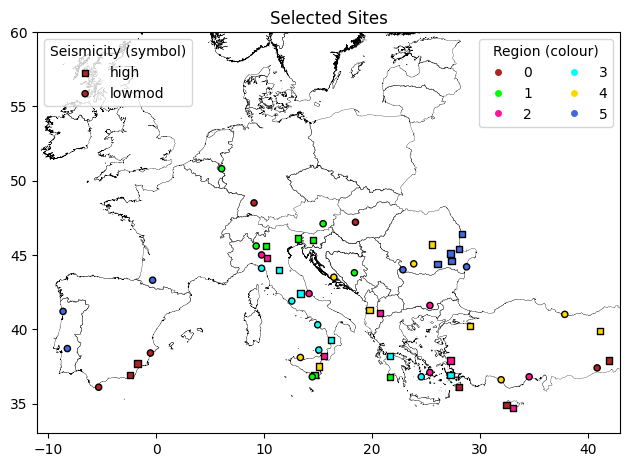

In [32]:
# plot the selected sites
fig, ax = plt.subplots()
alpha = 1
markersize = 20

gdf_eu.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2)

for seismicity, subset in sel_sites.groupby("seismicity"):
    marker = seismicity_symbols[seismicity]
    cols = subset["region"].map(colour_map)
    subset.plot(ax=ax, marker=marker, color=cols, markersize=markersize,
                edgecolor="k", linestyle="", label=seismicity)

# legend for B (colours)
col_legend = [
    Line2D([], [], marker="o", linestyle="", color=colour_map[bv],
           label=bv, markersize=4)
    for bv in colour_map
]

# legend for A (markers) - taken from plotted artists
marker_legend = ax.legend(title="Seismicity (symbol)", loc="upper left")

ax.add_artist(marker_legend)
ax.legend(handles=col_legend, title="Region (colour)", ncol=2,
          loc="upper right")

ax.set_title(r"Selected Sites")
ax.set_xlim(-11, 43)
ax.set_ylim(33, 60)
plt.tight_layout()

In [33]:
regionalised_stats_AvgSA.columns[:-2]

MultiIndex([('lowmod', 0),
            ('lowmod', 1),
            ('lowmod', 2),
            ('lowmod', 3),
            ('lowmod', 4),
            ('lowmod', 5),
            (  'high', 0),
            (  'high', 1),
            (  'high', 2),
            (  'high', 3),
            (  'high', 4),
            (  'high', 5)],
           )

Text(0, 0.5, 'Avg.SA(0->3s)')

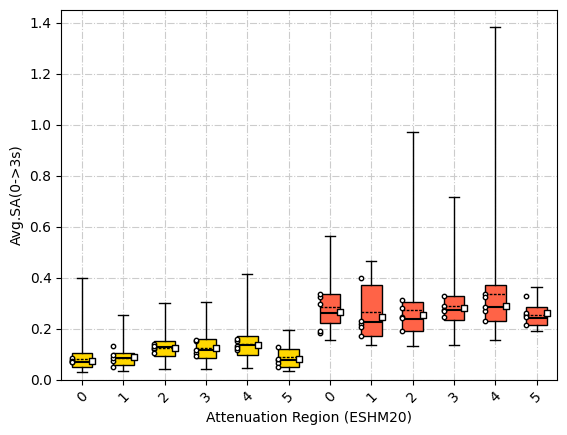

In [51]:
seismicity_colours = {"high": "tomato",
                      "lowmod": "gold"}

stats = []
sites = []
site_means = []
labels_lvl0 = []
labels_lvl1 = []

fig, ax = plt.subplots()

for col in regionalised_stats_AvgSA.columns[:-2]:
    s = regionalised_stats_AvgSA[col]

    iqr = s['75%'] - s['25%']

    stats.append({
        'med':  s['50%'],
        'q1':   s['25%'],
        'q3':   s['75%'],
        'whislo': s["min"],
        'whishi': s['max'],
        'mean': s['mean']
    })

    sites.append(sel_sites[(sel_sites["seismicity"] == col[0]) &
                           (sel_sites["region"] == col[1])])
    site_means.append(sites[-1]["AvgSA"].mean())

    labels_lvl0.append(str(col[0]))
    labels_lvl1.append(str(col[1]))

# Create the boxplot
bp = ax.bxp(stats, showmeans=True, 
            patch_artist=True, 
            showfliers=False,
            meanline=True)



# assign colours
for patch, col in zip(bp["boxes"], regionalised_stats_AvgSA.columns[:-2]):
    patch.set_facecolor(seismicity_colours[col[0]])
    patch.set_edgecolor("k")

for line in bp["medians"]:
    line.set_color("k")
    line.set_linewidth(1.5)

for line in bp["means"]:
    line.set_dashes((2,1))
    line.set_color("k")

# overlay sites + site mean
x_pos = [line.get_xdata()[0] for line in bp["medians"]]
x_off = 0.5
for s, sm, x in zip(sites, site_means, x_pos):
    xs = np.full(len(s["AvgSA"]), x)
    ax.scatter(xs, s["AvgSA"], zorder=5, s=10, edgecolors="k", c="w")
    ax.scatter(x + x_off, sm, zorder=5, s=15, edgecolors="k", c="w", marker="s")

# Set x-tick positions
pos = range(1, len(stats) + 1)
ax.set_xticks(pos)

# Create two-tier labels
ax.set_xticklabels(labels_lvl1)
ax.tick_params(axis='x', labelrotation=45)

ax.grid(True, which="both", color="0.8", ls=("-."))

# Add the upper level labels manually
# for x, lbl in zip(pos, labels_lvl0):
#     ax.text(x, 1.02, lbl, ha='center', va='bottom', transform=ax.transAxes)

ax.set_ylim(0,)
ax.set_xlabel('Attenuation Region (ESHM20)')
ax.set_ylabel(AvgSA_label)


Text(0, 0.5, 'Avg.SA(0->3s)')

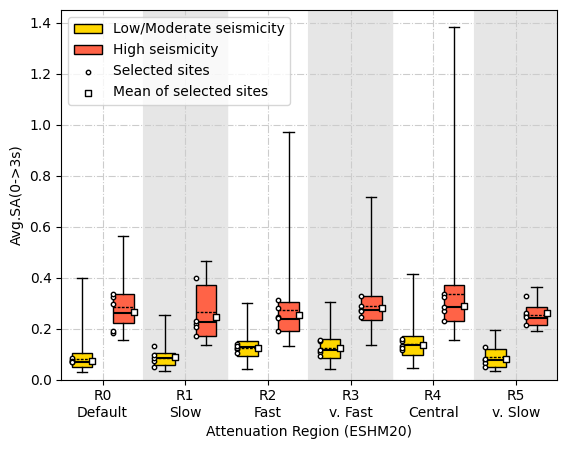

In [123]:
seismicity_colours = {"high": "tomato",
                      "lowmod": "gold"}

regions = [0, 1, 2, 3, 4, 5]
cols_lowmod = [("lowmod", r) for r in regions]
cols_high = [("high", r) for r in regions]

def extract_stats(df_desc, col):
    s = df_desc[col]
    return {
        'med': s['50%'], 'q1': s['25%'], 'q3': s['75%'],
        'whislo': s['min'], 'whishi': s['max'], 'mean': s['mean']
    }


stats = []
colours = []
sites = []
site_means = []

for r, cl, ch in zip(regions, cols_lowmod, cols_high):
    stats.append(extract_stats(regionalised_stats_AvgSA, cl))
    stats.append(extract_stats(regionalised_stats_AvgSA, ch))
    colours.append(seismicity_colours["lowmod"])
    colours.append(seismicity_colours["high"])

    sites.append(sel_sites[(sel_sites["seismicity"] == cl[0]) &
                           (sel_sites["region"] == cl[1])])
    site_means.append(sites[-1]["AvgSA"].mean())

    sites.append(sel_sites[(sel_sites["seismicity"] == ch[0]) &
                           (sel_sites["region"] == ch[1])])
    site_means.append(sites[-1]["AvgSA"].mean())
    

    # labels_lvl0.append(str(col[0]))
    # labels_lvl1.append(str(col[1]))


fig, ax = plt.subplots()

# Create the boxplot
bp = ax.bxp(stats, showmeans=True, 
            patch_artist=True, 
            showfliers=False,
            meanline=True)

# assign colours
for patch, colour in zip(bp["boxes"], colours):
    patch.set_facecolor(colour)
    patch.set_edgecolor("k")

for line in bp["medians"]:
    line.set_color("k")
    line.set_linewidth(1.5)

for line in bp["means"]:
    line.set_dashes((2,1))
    line.set_color("k")

# overlay sites + site mean
x_pos = [line.get_xdata()[0] for line in bp["medians"]]
x_off = 0.5
for s, sm, x in zip(sites, site_means, x_pos):
    xs = np.full(len(s["AvgSA"]), x)
    scat1 = ax.scatter(xs, s["AvgSA"], zorder=5, s=10, edgecolors="k", c="w", 
               label="sites")
    scat2 = ax.scatter(x + x_off, sm, zorder=5, s=15, edgecolors="k", c="w", 
                       marker="s", label="mean (sites)")

# Set x-tick positions
# X positions: 1..12
pos = np.arange(1, len(stats)+1)

# Tick: one per region, centred between the two boxes
tick_pos = pos.reshape(-1, 2).mean(axis=1)
region_labels = [f"R{r}\n{atten_label_map[r]}" for r in regions]
ax.set_xticks(tick_pos)
ax.set_xticklabels(region_labels, rotation=0)

# --- Shading odd-numbered regions (1,3,5) ---
# Each region covers 2 box positions
for i in range(len(regions)):
    if i % 2 == 1:       # odd region index
        left = 2*i + 1   # first box position for this region
        right = 2*i + 2  # second box
        ax.axvspan(left - 0.5, right + 0.5, color='0.9')

# Draw vertical separators between each region group
for sep in range(1, len(regions)):
    ax.axvline(x=2*sep + 0.5, color='0.9', linestyle='-')

ax.grid(True, which="both", color="0.8", ls=("-."))

# ------------------------------------------------------------
# Collect ONE representative handle for each scatter type
# ------------------------------------------------------------
handle_sites = None
handle_mean = None

for h in ax.collections:
    lbl = h.get_label()
    if lbl == "sites" and handle_sites is None:
        handle_sites = h
    if lbl == "mean (sites)" and handle_mean is None:
        handle_mean = h

# ------------------------------------------------------------
# Create legend entries for seismicity (box colours)
# ------------------------------------------------------------
low_patch = mpatches.Patch(facecolor=seismicity_colours["lowmod"],
                           edgecolor='black')
high_patch = mpatches.Patch(facecolor=seismicity_colours["high"],
                            edgecolor='black')

# ------------------------------------------------------------
# Combine everything into one legend
# ------------------------------------------------------------
handles = [low_patch, high_patch, handle_sites, handle_mean]
labels  = ['Low/Moderate seismicity', 'High seismicity', 
           'Selected sites', 'Mean of selected sites']

ax.legend(handles, labels, frameon=True,
          loc='upper left')

ax.set_ylim(0,)
ax.set_xlabel('Attenuation Region (ESHM20)')
ax.set_ylabel(AvgSA_label)
# ax.legend(hs_neu, ls_neu, loc="upper left")
